In [ ]:
!pip install activeSVC==4.0.1
!pip install psutil
!pip install h5py
!pip install scipy

In [17]:
import numpy as np
import time
import random
import os

from sklearn.preprocessing import normalize 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib import gridspec

from activeSVC import min_complexity_h5py, min_acquisition_h5py
import pandas as pd
import h5py
import pickle
import os, psutil
import resource
import scipy.sparse as sp_sparse
from scipy.sparse import vstack, hstack


def text_create(path, name, msg):
    full_path = path + "/" + name + '.pickle'
    f=open(full_path,'wb') 
    pickle.dump(msg,f)
    f.close()

class TimerError(Exception):
     """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Total run time: {elapsed_time:0.4f} seconds")
        return elapsed_time

def index_cell(data, indices, indptr, shape,index):
    i=index[0]
    matrix = sp_sparse.csc_matrix((data[indptr[i]:indptr[i+1]], indices[indptr[i]:indptr[i+1]],[0,indptr[i+1]-indptr[i]]),shape=(shape[0],1))
    for i in index[1:]:
        tmp=sp_sparse.csc_matrix((data[indptr[i]:indptr[i+1]], indices[indptr[i]:indptr[i+1]],[0,indptr[i+1]-indptr[i]]),shape=(shape[0],1))
        matrix=hstack((matrix,tmp))
    return matrix.transpose().tocsr()

def index_gene(data, indices, indptr, shape,index):
    i=index[0]
    matrix = sp_sparse.csr_matrix((data[indptr[i]:indptr[i+1]], indices[indptr[i]:indptr[i+1]],[0,indptr[i+1]-indptr[i]]),shape=(1,shape[1]))
    for i in index[1:]:
        tmp=sp_sparse.csr_matrix((data[indptr[i]:indptr[i+1]], indices[indptr[i]:indptr[i+1]],[0,indptr[i+1]-indptr[i]]),shape=(1,shape[1]))
        matrix=vstack((matrix,tmp))
    return matrix.transpose()

# Download and Load Brain Data

## Please download the data folder from this dropbox link, as the dataset is too large to upload or auto-downlaod here.  
https://www.dropbox.com/sh/8b3kf59chod6o5j/AADiLQbHZFQqN4FXGda_N5MZa?dl=0

In [20]:

df = pd.read_csv('./data/clusters10.csv', index_col=0)
y=df['Cluster'].values
classes = np.unique(y)
keys=classes

f = h5py.File('./data/norm_1M_neurons_filtered_gene_bc_matrices_h5.h5', 'r')
h5data=f['mm10']
data_cell=h5data['data']
indices_cell=h5data['indices']
indptr_cell = h5data['indptr']
shape=h5data['shape']

f = h5py.File('./data/norm_transpose_1M_neurons_filtered_gene_bc_matrices_h5.h5', 'r')
h5data=f['mm10']
data_gene=h5data['data']
indices_gene=h5data['indices']
indptr_gene = h5data['indptr']

gene_name=pd.read_csv("./data/gene_name.csv",delimiter=",",header=None)[0].values

df = pd.read_csv('./data/projection.csv', index_col=0)
tsne1=df['TSNE-1'].values
tsne2=df['TSNE-2'].values

idx = np.arange(shape[1])
random.shuffle(idx)
idx_train=idx[:int(shape[1]*4/5)]
idx_test=idx[int(shape[1]*4/5):]
print(shape[1],shape[0])


1306127 27998


# min_complexity

## Define Parameters and Work Space

In [9]:
'''
Parameters
'''
num_features = 10
num_samples=20
init_samples=20
balance=False

folder='results/min_complexity'
path=folder+'/test_'+str(num_features)+'_'+str(num_samples)

try:
    os.mkdir('results')
except OSError:
    print ("Creation of the directory %s failed" % 'results')
else:
    print ("Successfully created the directory %s " % 'results')
try:
    os.mkdir(folder)
except OSError:
    print ("Creation of the directory %s failed" % folder)
else:
    print ("Successfully created the directory %s " % folder)
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory results failed
Creation of the directory results/min_complexity failed
Successfully created the directory results/min_complexity/test_10_50 


## Select Genes and Save Results

Elapsed time: 3.3693 seconds
feature 0 : gene [5131]  50 samples
training error=3.9460695319460886 test error=3.9316032860435026
training accuracy=0.4803775668699714 test accuracy=0.4794316032860435
Elapsed time: 88.3586 seconds
feature 1 : gene 903  100 samples
training error=2.841507472956768 test error=2.8194015909595525
training accuracy=0.5705440036903018 test accuracy=0.5709041213355486
Elapsed time: 79.5794 seconds
feature 2 : gene 6412  150 samples
training error=2.436601170828624 test error=2.421018581611325
training accuracy=0.6185466374326372 test accuracy=0.6186750170350578
Elapsed time: 74.3526 seconds
feature 3 : gene 23641  200 samples
training error=2.0444290894544075 test error=2.0153774892238903
training accuracy=0.6368584200799884 test accuracy=0.63712264475971
Elapsed time: 59.1228 seconds
feature 4 : gene 14438  250 samples
training error=1.9923992799317831 test error=1.969769471645242
training accuracy=0.6508922854892473 test accuracy=0.6514512337975547
Elapsed ti

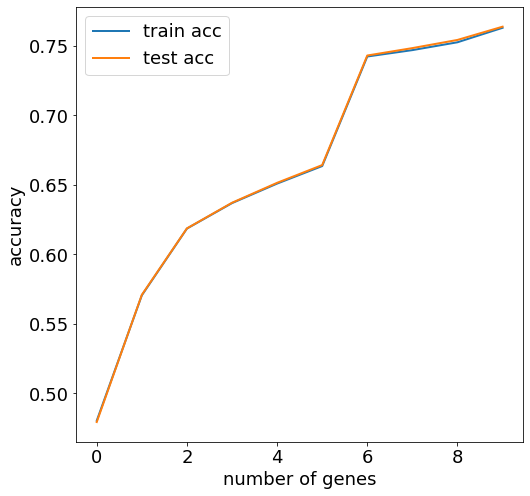

In [10]:
if __name__ == '__main__':

    t=Timer()
    t.start()
    feature_selected, num_samples_list, train_errors,test_errors,train_scores,test_scores,step_times= min_complexity_h5py(
        data_cell,indices_cell,indptr_cell,data_gene,indices_gene,indptr_gene, y, shape,idx_train,idx_test, 
        num_features=num_features,num_samples=num_samples,init_features=1,init_samples=init_samples, balance=balance)
    elapsed_time=t.stop()
    
    memorys=[]
    memorys.append(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)
    memorys.append(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/ 1024 ** 2)
    
    text_create(path,'feature_selected',feature_selected)
    text_create(path,'error',train_errors+test_errors)
    text_create(path,'accuracy',train_scores+test_scores)
    text_create(path,'num_samples_list',num_samples_list)
    text_create(path,'genes_name',gene_name[feature_selected])
    text_create(path,'elapsed_time',elapsed_time)
    text_create(path,'memory',memorys)

    plt.figure(figsize=(8,8))
    plt.plot(train_scores,linewidth=2)
    plt.plot(test_scores,linewidth=2)
    plt.legend(['train acc','test acc'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('accuracy',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/acc.pdf', bbox_inches="tight")

# min_aquisition

## Define Parameters and Work Space

In [11]:
'''
Parameters
'''
num_features = 10
num_samples=100
init_samples=100

folder='results/min_acquisition'
path=folder+'/test_'+str(num_features)+'_'+str(num_samples)

try:
    os.mkdir('results')
except OSError:
    print ("Creation of the directory %s failed" % 'results')
else:
    print ("Successfully created the directory %s " % 'results')
try:
    os.mkdir(folder)
except OSError:
    print ("Creation of the directory %s failed" % folder)
else:
    print ("Successfully created the directory %s " % folder)
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory results failed
Creation of the directory results/min_acquisition failed
Successfully created the directory results/min_acquisition/test_10_100 


## Select Genes and Save Results

Elapsed time: 5.5741 seconds
feature 0 : gene [6412]  100 samples
training error=3.9865068556734085 test error=3.9695550978845904
training accuracy=0.47422100275528495 test accuracy=0.47293914082059213
Elapsed time: 79.8957 seconds
feature 1 : gene 663  200 samples
training error=2.790316977397859 test error=2.777124022876743
training accuracy=0.5183467141863201 test accuracy=0.5174370085672942
Elapsed time: 73.3901 seconds
feature 2 : gene 7838  270 samples
training error=1.9553105988031403 test error=1.9538598761225912
training accuracy=0.5472231340576763 test accuracy=0.5467755889536263
Elapsed time: 66.3803 seconds
feature 3 : gene 10741  312 samples
training error=2.0837256352515694 test error=2.074743708512935
training accuracy=0.5898329124003135 test accuracy=0.5904389302749343
Elapsed time: 66.4483 seconds
feature 4 : gene 23641  346 samples
training error=1.916103056653214 test error=1.9069962408029828
training accuracy=0.6383791383107108 test accuracy=0.6390596648113128
Elaps

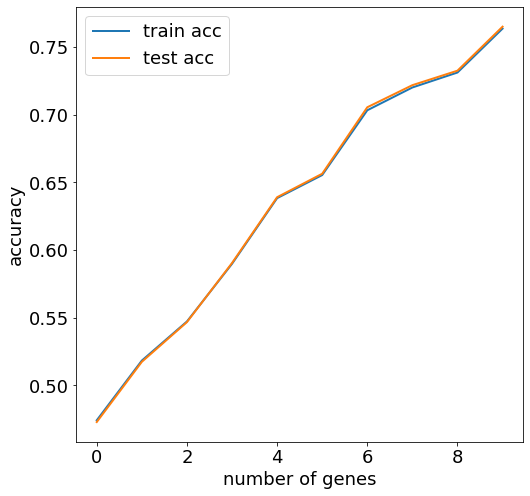

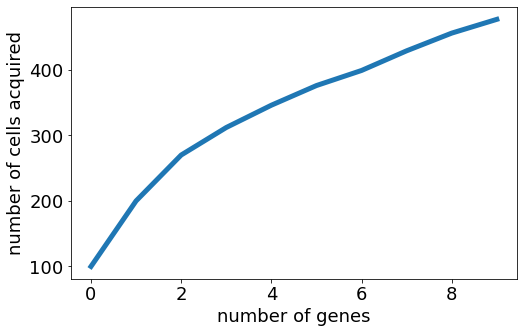

In [12]:
if __name__ == '__main__':

    t=Timer()
    t.start()
    feature_selected, num_samples_list, samples_global, train_errors,test_errors,train_scores,test_scores,step_times= min_acquisition_h5py(
        data_cell,indices_cell,indptr_cell,data_gene,indices_gene,indptr_gene, y, shape,idx_train,idx_test,
        num_features=num_features,num_samples=num_samples,init_features=1,init_samples=init_samples,balance=balance)
    elapsed_time=t.stop()
    
    memorys=[]
    memorys.append(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)
    memorys.append(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/ 1024 ** 2)
    
    text_create(path,'feature_selected',feature_selected)
    text_create(path,'error',train_errors+test_errors)
    text_create(path,'accuracy',train_scores+test_scores)
    text_create(path,'num_samples_list',num_samples_list)
    text_create(path,'samples_global',samples_global)
    text_create(path,'genes_name',gene_name[feature_selected])
    text_create(path,'elapsed_time',elapsed_time)
    text_create(path,'memory',memorys)

    plt.figure(figsize=(8,8))
    plt.plot(train_scores,linewidth=2)
    plt.plot(test_scores,linewidth=2)
    plt.legend(['train acc','test acc'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('accuracy',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/acc.pdf', bbox_inches="tight")

    plt.figure(figsize=(8,5))
    plt.plot(num_samples_list,linewidth=5)
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('number of cells acquired',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/cells.pdf', bbox_inches="tight")

# Plots

## Sampling

In [18]:
sampling=np.arange(shape[1])
random.shuffle(sampling)

matrix=index_cell(data_cell,indices_cell,indptr_cell, shape, sampling[:30000]).toarray()
target=y[sampling[:30000]]
import pickle
f=open(path+'/sampling.pickle','wb') 
pickle.dump(sampling,f)
f.close()

## T-SNE

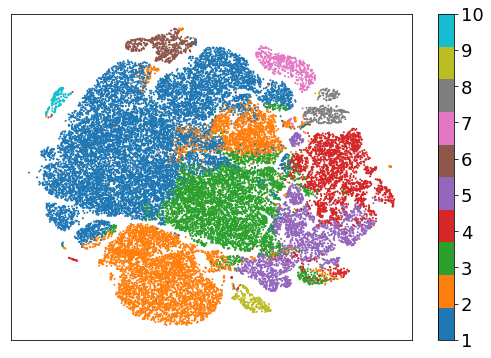

In [21]:
plt.figure(figsize=(9,6))
c_cmap = plt.get_cmap('tab10', len(classes))
plt.scatter(tsne1[sampling[:30000]],tsne2[sampling[:30000]],c=target,s=1,cmap=c_cmap)
cbar=plt.colorbar(ticks=np.arange(1,len(classes)+1))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(keys,fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne.png',dpi=300,  facecolor='white',bbox_inches="tight")

## Gene Markers

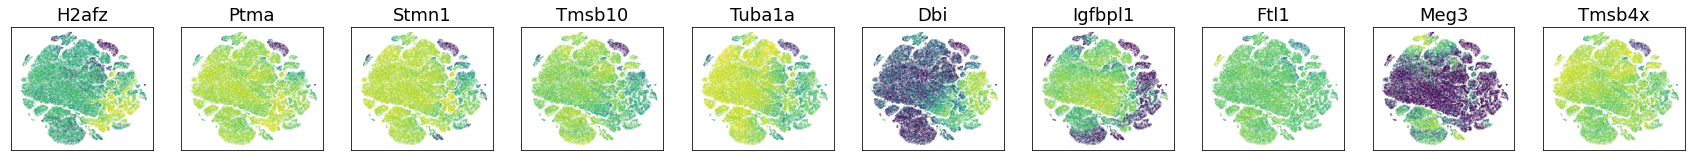

In [22]:
alpha = 10000
num_col=10
data_show = np.log1p(matrix*alpha)

size=len(feature_selected)
plt.figure(figsize=(3*num_col,2.5*(int(size/num_col)+1)))
gs = gridspec.GridSpec(int(size/num_col)+1, num_col, width_ratios=[7]*num_col)

for i in range(size):
    f=feature_selected[i]
    ax0 = plt.subplot(gs[i])
    ax0.set_title(gene_name[f],fontdict={'weight':'normal','size': 18})
    plt.scatter(tsne1[sampling[:30000]],tsne2[sampling[:30000]],c=data_show[:,f],s=0.01)
    ax0.set_xticks([])
    ax0.set_yticks([])
plt.savefig(path+'/genes.png',dpi=300,  facecolor='white',bbox_inches="tight")   


